In [252]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import json
import sys
import yaml

In [245]:
def load_config(config_path):
    '''Load configuration from YAML file'''
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

## Define matrices

In [232]:
def create_spin_chain_mps(N: int, chi: int, seed: int, min_val: float, max_val: float, dtype=jnp.float32):
    '''Creates list of tensors that define the MPS of a quantum spin 1/2 chain
    The first and last tensors will have two indices, the rest have 3
    The first index has dimension 2, and the rest have bond dimension equal to chi
    '''
    
    # Create random keys
    key = jax.random.PRNGKey(seed)
    keys = jax.random.split(key, N)
    
    # Scale factor for uniform distribution
    scale_factor = max_val - min_val
    
    # Initialize tensor list
    mps = []
    
    # First tensor
    mps.append(min_val + scale_factor * jax.random.uniform(keys[0], (2, chi), dtype=dtype))
    
    # Middle tensors
    for i in range(1, N-1):
        mps.append(min_val + scale_factor * jax.random.uniform(keys[i], (2, chi, chi), dtype=dtype))
    
    # Last tensor
    mps.append(min_val + scale_factor * jax.random.uniform(keys[N-1], (2, chi), dtype=dtype))
    
    return mps



## Sample bitstrings from the MPS

In [233]:
def generate_bitstring_list(nqubits):
    bitstrings = []
    decimal_bitstrings = range(0, 2**nqubits)
    int_bitstrings = [bin(i)[2:].zfill(nqubits) for i in decimal_bitstrings]
    bitstrings =  [str(bit) for bit in int_bitstrings]

    return bitstrings

def get_amplitude(mps, string):
    current = mps[0][int(string[0])]
    # Contract with middle tensors
    for i in range(1, N-1):
        tensor_slice = mps[i][int(string[i])]
        
        current = jnp.dot(current, tensor_slice)
    
    # Contract with last tensor
    last_slice = mps[-1][int(string[-1])]
    
    # Final contraction gives scalar
    amplitude = float(jnp.dot(current, last_slice))
    
    return amplitude

def extract_amplitudes(mps):
    num_qubits = len(mps)
    bitstrings = generate_bitstring_list(num_qubits)
    probs = []
    for string in bitstrings:
        amp = get_amplitude(mps, string)
        probs.append(amp**2)

    total_prob = sum(probs)
    normalized_probs = [p/total_prob for p in probs]
    return bitstrings, normalized_probs


def sample_from_probs(nqubits, N_shots, probs, seed):
    dim = 2**nqubits
    counts_shots = []
    rng = np.random.default_rng(seed)
    samples = rng.choice(dim, size=N_shots, p=probs)
    hist = np.bincount(samples, minlength=dim)
    counts_shots.append(hist)

    return counts_shots


In [269]:
def print_run_info(config):
    print(f"Generating data for MPS of size {config['L']}, " \
          f"with bond dimension {config['bond_dimension']} and values " \
          f"between {config['min_val']} and {config['max_val']} " \
          f"and {config['N_shots']} shots")
    return


In [271]:
config_file = "/Users/omichel/Desktop/qilimanjaro/projects/retech/retech_2025/config_files/data_generation_configuration.yaml"
#load configuration
print(config_file)
CONFIG = load_config(config_file)

# Test
seed = CONFIG['seed_data']
N = CONFIG['L']
chi = CONFIG['bond_dimension']
min_val = CONFIG['min_val']
max_val = CONFIG['max_val']
N_shots = CONFIG['N_shots']
print_run_info(CONFIG)

mps = create_spin_chain_mps(N, chi, seed, min_val, max_val)

# Check the shapes
print(f"Number of tensors: {len(mps)}")
for i, tensor in enumerate(mps):
    print(f"Tensor {i}: shape = {tensor.shape}")

bitstrings, probs = extract_amplitudes(mps)

/Users/omichel/Desktop/qilimanjaro/projects/retech/retech_2025/config_files/data_generation_configuration.yaml
Generating data for MPS of size 4, with bond dimension 4 and values between 0 and 1 and 10000 shots
Number of tensors: 4
Tensor 0: shape = (2, 4)
Tensor 1: shape = (2, 4, 4)
Tensor 2: shape = (2, 4, 4)
Tensor 3: shape = (2, 4)


In [267]:
def bar_plot_strings(strings, values, title="Bar Plot", xlabel="Categories", ylabel="Values", 
                     color='skyblue', edgecolor='black', figsize=(10, 6)):
    """
    Quick bar plot with string labels on x-axis.
    
    Parameters:
    -----------
    strings : list of str
        Labels for x-axis (bar categories)
    values : list of float/int
        Values for y-axis (bar heights)
    title : str
        Plot title
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
    color : str or list
        Bar color(s)
    edgecolor : str
        Bar edge color
    figsize : tuple
        Figure size (width, height)
    """
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create bar plot
    x_pos = np.arange(len(strings))
    bars = ax.bar(x_pos, values, color=color, edgecolor=edgecolor, alpha=0.8)
    
    # Customize plot
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    # Set x-ticks to string labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(strings, rotation=45, ha='right', fontsize=10)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Add grid for better readability
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig, ax, bars

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Bitstring probabilities'}, xlabel='Categories', ylabel='Values'>,
 <BarContainer object of 16 artists>)

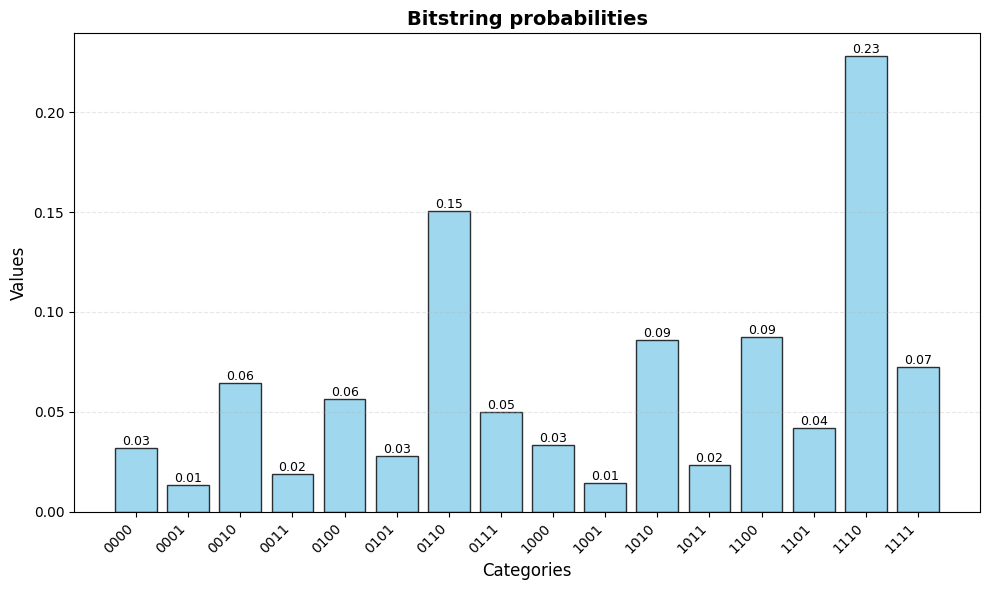

In [268]:
bar_plot_strings(bitstrings, probs, "Bitstring probabilities")

In [272]:
counts_shots = sample_from_probs(N, N_shots, probs, seed)

In [273]:
print(counts_shots[0])

[ 334  144  611  186  570  271 1503  507  319  131  864  251  895  436
 2241  737]


In [ ]:
def save_simple_bitstrings(bitstrings, counts, prefix = None):
    #Create config file and save here L, chi, Nshots
    filename_core = f"L{N}_Chi_{chi}_R{N_shots}"

    filename = f'experimental_data_{prefix}_{filename_core}_counts.csv'
    
    df = pd.DataFrame({'bitstring': bitstrings, 'count': counts})
    df.to_csv(filename, index=False)

    print(f"Saved to {filename}")
    return filename

In [284]:
files = save_simple_bitstrings(
    bitstrings=bitstrings,
    counts=counts_shots,
    prefix="quantum_sampling"
    )

Saved to experimental_data_quantum_sampling_L4_Chi_4_R10000_counts.csv
